#Project 1 - Report 1 code

In [32]:
#Please have the 'playlists4000.txt' file in the same directory as this notebook.

fd = open("playlists4000.txt",mode='r',encoding='utf8',newline='\n')

raw = fd.read().splitlines()

hashtable = dict()

for line in raw:
    first, second = line.split(sep="::")
    hashtable.setdefault(first, []).append(second)

In [33]:
#Number of items
items = 0
for x in hashtable.values():
    items += len(x)
items

55994

In [34]:
#Number of transactions
len(hashtable.keys())

4000

In [35]:
#Longest transaction
longest = 0
for x in hashtable.values():
    if (len(x) > longest):
        longest = len(x)

longest

110

In [36]:
#Shortest transaction
shortest = longest
for x in hashtable.values():
    if(len(x) < shortest):
        shortest = len(x)
shortest

1

In [37]:
#Support counting

#Dictionary of 1-itemsets with support count

counts = dict()

for line in raw:
    first, second = line.split(sep="::")
    x = counts.setdefault(second,0)
    counts[second] = x+1

In [38]:
#Number of frequent 1-itemsets with support count threshold 400
freq = 0

for x in counts:
    if(counts[x] > 400):
        freq += 1

freq

0

Turns out there are no 1-temsets with a support of 400

In [39]:
#Highest support for a 1-itemset
max(counts.values())

194

In [40]:
import pandas as pd

df_counts = pd.DataFrame.from_dict(counts, orient='index')

df_counts = df_counts.set_axis(['support'],axis=1)

df_counts.head()

,support
0,132
1,106
2,123
3,77
4,86


In [54]:
plot_df = df_counts.loc[df_counts['support'] > 50]

plot_df = plot_df.sort_values(by=['support']).reset_index()

plot_df = plot_df.rename(columns={'index' : 'Items','support':'Support'})

plot_df

,Items,Support
0,541,51
1,805,51
2,315,51
3,322,51
4,439,51
...,...,...
329,320,172
330,167,172
331,297,186
332,203,187


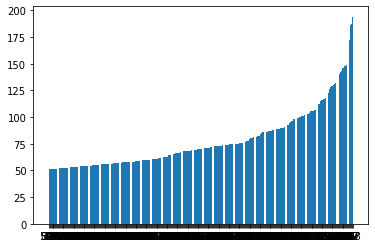

In [58]:
import matplotlib.pyplot as plt

plt.bar(plot_df['Items'], plot_df['Support'])
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()